In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from rhozy_code import bug
import numpy as np
import sys
sys.version

'3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]'

# __Optimisation__
## Obtaining optimal growth Cs (for highest μ)
## Obtaining ethanol overflow threshold (batch fermentation to observe at what initial Cs ethanol production starts)

<IPython.core.display.Javascript object>


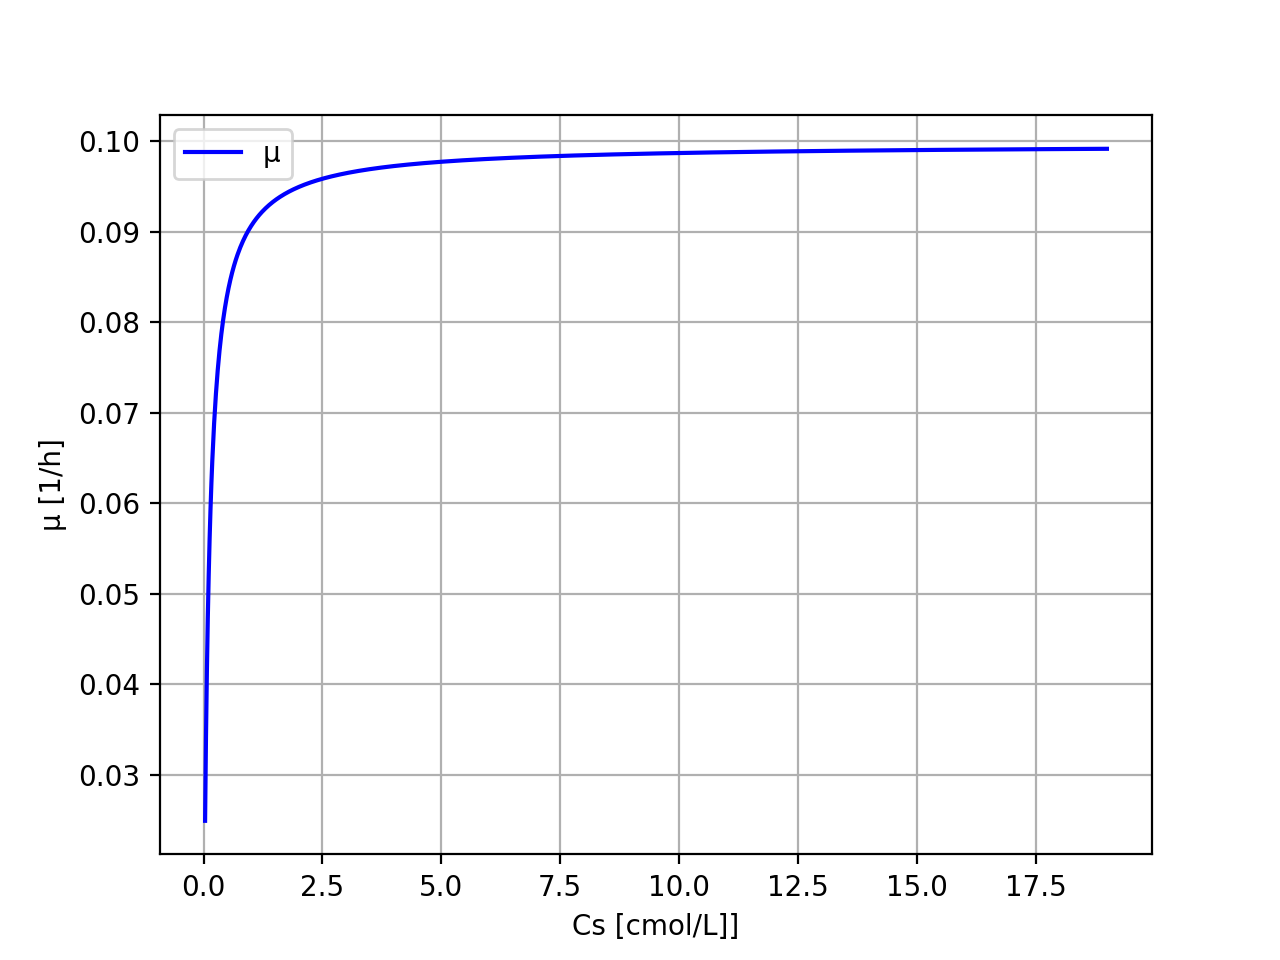

In [7]:
"""1.1"""
#############################################
MM_s=180/6 #g/cmol
MM_x=(10*(12)+18*(1)+5*(16)+2*(14))/10 #g/cmol
MM_f=116/4 #g/cmol
MM_e=46/2 #g/cmol
MM_n=53.5/1 #g/cmol

Cx=1.23/MM_x #cmol/L
Cf=10/MM_f #cmol/L
Ce=10/MM_f #cmol/L
Cn=10/MM_f #cmol/L
#############################################
Cs_arr=np.linspace(1,570,1000)/MM_s #g/L
mu_arr=[]
for i,Cs in enumerate(Cs_arr):
    r=bug([Cs,Cx,Cf,Ce,Cn],1,1,1)
    mu_arr.append(r[1])
#############################################
%matplotlib notebook
plt.figure(0)
plt.plot(Cs_arr, mu_arr, 'b', label = "μ")
plt.xlabel("Cs [cmol/L]]")
plt.ylabel("μ [1/h]")
plt.grid(True)
plt.legend(loc = "best")

C:\Users\angol\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


<IPython.core.display.Javascript object>


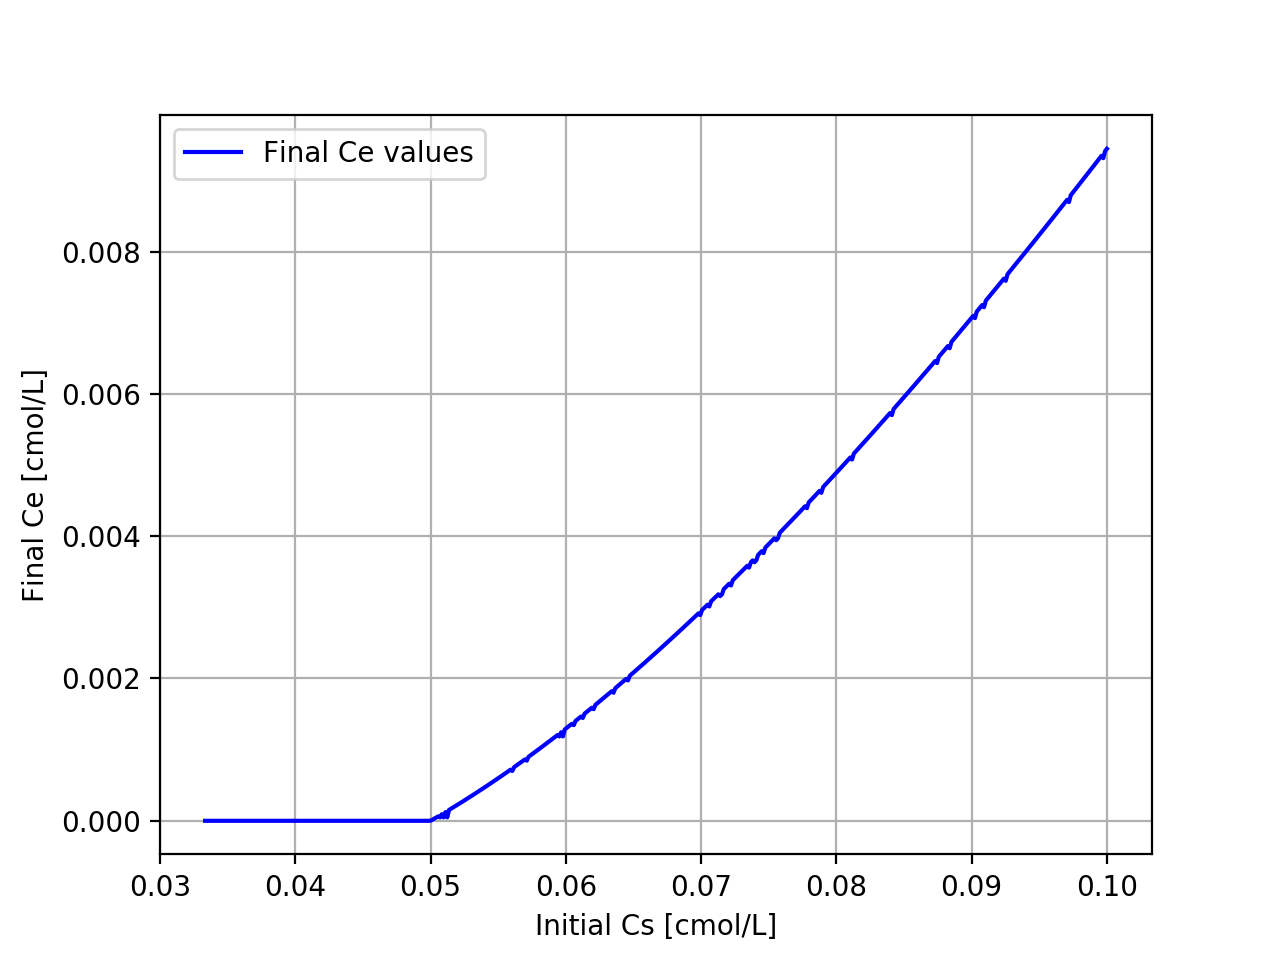

In [2]:
"""1.2"""
#####################################################
MM_x=(10*(12)+18*(1)+5*(16)+2*(14))/10 #g/cmol
MM_s=180/6 #g/cmol
#####################################################
C_i=[None,1.23/MM_x,0,0,5/53.5] #cmol/L
C_f=[0,0,0,0,0] #cmol/L
tmax=10
######################################################
def resp_fn(C):
    r= bug(C,1,1,1)
    return r
def ferm_fn(C,t):
    Cx=C[1]
    rs,rx,rf,re,rn=resp_fn(C)
    return [rs*Cx,
            rx*Cx,
            rf*Cx,
            re*Cx,
            rn*Cx]
##############################################
tspan=np.linspace(0,tmax,1000)
Cs_i_arr=np.linspace(1,3,500)/MM_s
Ce_final_arr=[]
for i,Cs_i in enumerate(Cs_i_arr):
    C_i[0]=Cs_i
    Cs,Cx,Cf,Ce,Cn=odeint(ferm_fn,C_i,tspan).T
    Ce_final_arr.append(Ce[-1])
##############################################
%matplotlib notebook
plt.figure(0)
plt.plot(Cs_i_arr, Ce_final_arr, 'b', label = "Final Ce values")
plt.xlabel("Initial Cs [cmol/L]")
plt.ylabel("Final Ce [cmol/L]")
plt.grid(True)
plt.legend(loc = "best")

# __Design simulation__
Fed-batch with growth (excess nitrogen) and production phase (no nitrogen), using optimal Cs value (just below ethanol overflow threshold), max feed glucose concentration and optial production phase switch time


Fermentation end time: 91.976 h
Final volume 109.34746970831785 L
_________________________________________________
Productivity: 0.5436200748021223 g/(L*h)
Fumarate yield: 0.8765254589742474 g/g
Ethanol yield: 0.0 g/g
OF: 100.0007186839352
_________________________________________________
Total CO2 produced: -2.7695294992999298 mol
Total O2 consumed: 3.83681776729791 mol


<IPython.core.display.Javascript object>


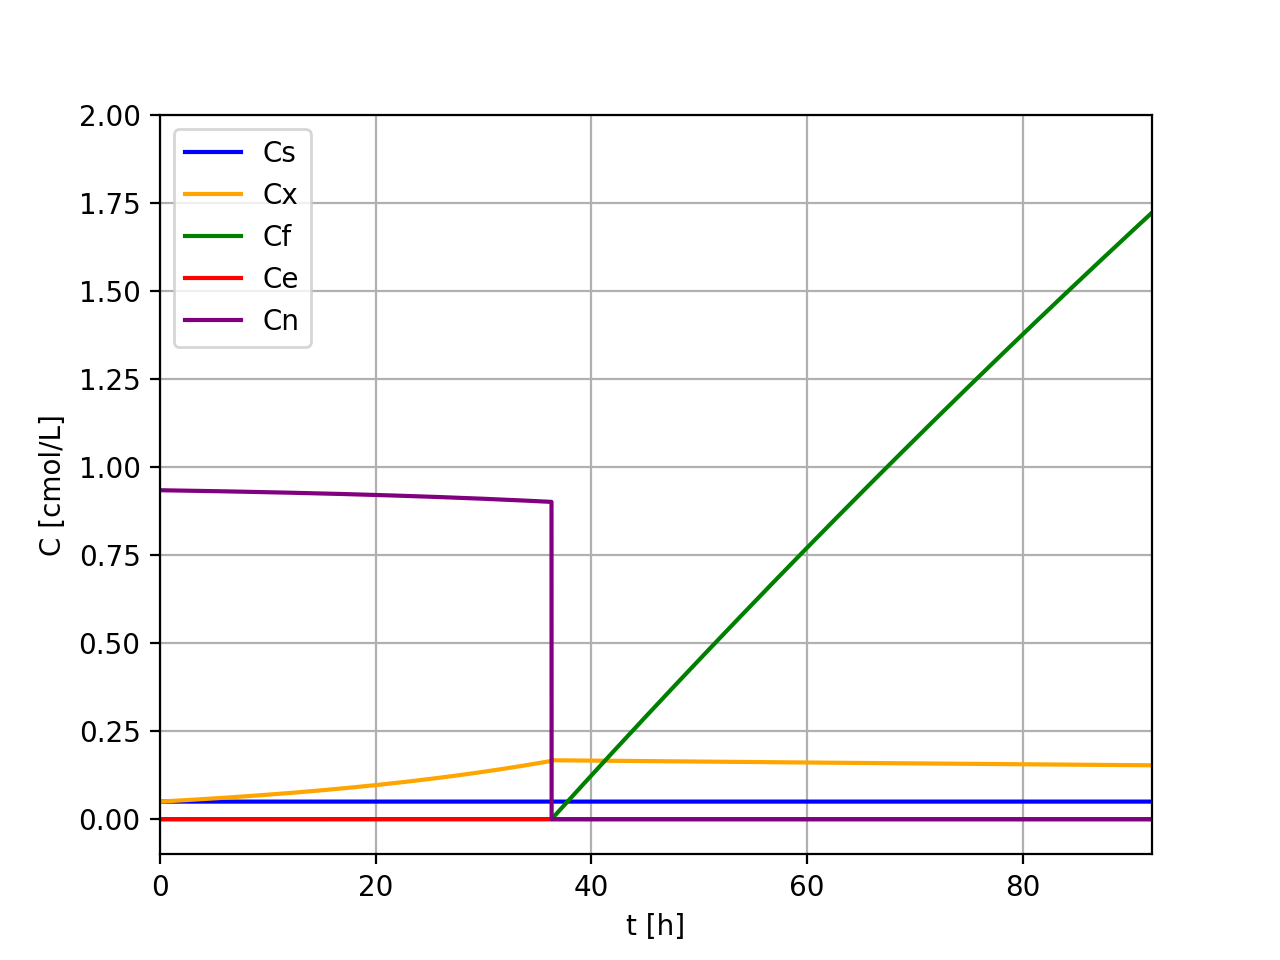

In [4]:
"""Design simulation"""
#############################################
"""other constants"""
MM_s=180/6 #g/cmol
MM_x=(10*(12)+18*(1)+5*(16)+2*(14))/10 #g/cmol
MM_f=116/4 #g/cmol
MM_e=46/2 #g/cmol
MM_n=53.5/1 #g/cmol
alpha=0.1 #mol/cmol_x
beta=0.1 #mol/cmol_x
tmax=500
resolution=1e-3

"""design constraints"""
Cf_end=50/MM_f #cmol/L
mass_i_x=123 #g #Starting biomass: 123g
#V: 100L to 2000L
#Cs_f max: 570 g/L

"""fermenter specifications"""
#growth phase
V_i_growth=100 #L
C_i_growth=[1.499999/MM_s,mass_i_x/(V_i_growth*MM_x),0/MM_f,0/MM_e,50/MM_n] #cmol/L #1.499916
C_f_growth=[570/MM_s,0/MM_x,0/MM_f,0/MM_e,0/MM_n] #cmol/L

#production phase
t_prod=36.3 #h (Production phase. Cx is kept, all other concentrations specified again) 36.3
V_i_prod=100 #L
C_i_prod=[1.499999/MM_s,None,0/MM_f,0/MM_e,0/MM_n] #cmol/L 
C_f_prod=[570/MM_s,0/MM_x,0/MM_f,0/MM_e,0/MM_n] #cmol/L
##############################################
def ferm_fn(N,t,C_f):
    Cs,Cx,Cf,Ce,Cn,V=N[0]/N[5],N[1]/N[5],N[2]/N[5],N[3]/N[5],N[4]/N[5],N[5]
    rs,rx,rf,re,rn=bug([Cs,Cx,Cf,Ce,Cn],1,1,1)#response function
    rco2=-rs-rx-rf #co2 production rate
    #rco2=alpha*rx+(-rs-rx*(alpha+1))-rf-(1/4)*rf
    ro2=(beta*rx+(7/3)*(-rs-rx*(alpha+1))-(9/4)*rf)/2 #o2 rate
    Q=rs*Cx*V/(Cs-C_f[0])
    return [Q*C_f[0]+rs*Cx*V,#glucose
            Q*C_f[1]+rx*Cx*V,#biomass
            Q*C_f[2]+rf*Cx*V,#fumaric acid
            Q*C_f[3]+re*Cx*V,#ethanol
            Q*C_f[4]+rn*Cx*V,#ammonium chloride
            Q,#get volume
            Q*C_f[0],#total glucose fed 
            rco2*Cx*V,#co2 produced
            ro2*Cx*V]#o2 used
##############################################
"""integration"""
#growth
tspan_growth=np.arange(0,t_prod,resolution)
N_i_growth=list(np.array(C_i_growth)*V_i_growth)+[V_i_growth]+[0,0,0]
Ns_growth,Nx_growth,Nf_growth,Ne_growth,Nn_growth,V_growth,Ns_fed_growth,Nco2_growth,No2_growth=odeint(ferm_fn,N_i_growth,tspan_growth,args=(C_f_growth,)).T

Cs_growth=list(Ns_growth/V_growth)
Cx_growth=list(Nx_growth/V_growth)
Cf_growth=list(Nf_growth/V_growth)
Ce_growth=list(Ne_growth/V_growth)
Cn_growth=list(Nn_growth/V_growth)

#production
tspan_prod=np.arange(t_prod,tmax,resolution)
N_i_prod=[C_i_prod[0]*V_i_prod]+[Nx_growth[-1]]+list(np.array(C_i_prod[2:5])*V_i_prod)+[V_i_prod]+[Ns_fed_growth[-1]]+[Nco2_growth[-1]]+[No2_growth[-1]] #includes biomass from growth
Ns_prod,Nx_prod,Nf_prod,Ne_prod,Nn_prod,V_prod,Ns_fed_prod,Nco2_prod,No2_prod=odeint(ferm_fn,N_i_prod,tspan_prod,args=(C_f_prod,)).T

Cs_prod=list(Ns_prod/V_prod)
Cx_prod=list(Nx_prod/V_prod)
Cf_prod=list(Nf_prod/V_prod)
Ce_prod=list(Ne_prod/V_prod)
Cn_prod=list(Nn_prod/V_prod)
                
#growth+production
tspan=np.arange(0,tmax,resolution)
Cs=Cs_growth+Cs_prod
Cx=Cx_growth+Cx_prod
Cf=Cf_growth+Cf_prod
Ce=Ce_growth+Ce_prod
Cn=Cn_growth+Cn_prod
V=list(V_growth)+list(V_prod)
Ns_fed=list(Ns_fed_growth)+list(Ns_fed_prod)
Nco2=list(Nco2_growth)+list(Nco2_prod)
No2=list(No2_growth)+list(No2_prod)
##############################################
"""OF calculation"""
#assumes that no fumaric acid produced in growth phase
for i,t in enumerate(tspan):
    t_end=0
    if (abs(Cf[i]-Cf_end)<=1e-3):
        t_end=t
        i_end=i
        break
if (t_end>0):
    P=Cf_end*MM_f/t_end#g/(L*h)
    total_s=C_i_growth[0]*V_i_growth+C_i_prod[0]*V_i_prod+Ns_fed[i_end]#cmol
    yield_f=(Cf_end*V[i_end]/total_s)*(MM_f/MM_s)#g/g
    yield_e=((Ce_growth[-1]*V_growth[-1]+Ce[i_end]*V[i_end])/total_s)*(MM_e/MM_s)#g/g
    OF=239.43*P*yield_f**2-1100*yield_e
##############################################
"""output"""
if (t_end>0):
    print("Fermentation end time:",t_end,"h")
    print("Final volume",V[i_end],"L")
    print("_________________________________________________")
    print("Productivity:",P,"g/(L*h)")
    print("Fumarate yield:",yield_f,"g/g")
    print("Ethanol yield:",yield_e,"g/g")
    print("OF:",OF)
    print("_________________________________________________")
    print("Total CO2 produced:",Nco2[i_end],"mol")
    print("Total O2 consumed:",No2[i_end],"mol")
    %matplotlib notebook
    plt.figure(0)
    plt.xlabel("t [h]")
    plt.ylabel("C [cmol/L]")
    plt.xlim(0,t_end)
    plt.ylim(-0.1,2)
    plt.grid(True)
    plt.plot(tspan,Cs,'b',label="Cs")
    plt.plot(tspan,Cx,'orange',label="Cx")
    plt.plot(tspan,Cf,'g',label="Cf")
    plt.plot(tspan,Ce,'r',label="Ce")
    plt.plot(tspan,Cn,'purple',label="Cn")
    plt.legend(loc="best")
else:
    print("fermentation did not reach fumaric acid specification.")
    %matplotlib notebook
    plt.figure(0)
    plt.xlabel("t [h]")
    plt.ylabel("C [cmol/L]")
    plt.xlim(0,tmax)
    plt.ylim(-0.1,2)
    plt.grid(True)
    plt.plot(tspan,Cs,'b',label="Cs")
    plt.plot(tspan,Cx,'orange',label="Cx")
    plt.plot(tspan,Cf,'g',label="Cf")
    plt.plot(tspan,Ce,'r',label="Ce")
    plt.plot(tspan,Cn,'purple',label="Cn")
    plt.legend(loc="best")